# Prius Data Tests 

This notebook is built to display the concepts learned within the <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/">Learn & Use section</a> of the <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/">Tensorflow tutorials</a>.

The data for this example consists of over 11 years of mileage data from my 2006 Prius.  The data is a simple CSV file containing mileage, fuel, distance, MPG estimate, date and actual MPG.  MPG Estimate is a reading from the car's display that shows what the car thinks its current MPG is.  This was reset during each fillup.  Additionally, the car was nearly always filled when it was on the last notch after the add fuel warning started to display.  Gas was added and rounded off to whole dollars during fillup.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.11.0'

In [2]:
# Extract the month and return it as an int
def extract_month_from_string(date):
    x = date.split("/")
    return int(x[0])

In [3]:
raw_dataset = pd.read_csv('data/PriusMileageInfo.csv', header=0)
# FROM http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
raw_dataset['Date'].apply(extract_month_from_string)

# Save the result in a new column
raw_dataset['month'] = raw_dataset['Date'].apply(extract_month_from_string)
raw_dataset.head()

,Date,Mileage,Fuel,MPG_Estimate,Distance,MPG_Actual,Comments,month
0,8/20/06,391,10.000,39.1,391,39.100,Filled by dealer,8
1,9/8/06,833,8.891,NaN,442,49.713,NaN,9
2,9/29/06,1289,10.220,46.7,456,44.618,NaN,9
3,10/17/06,1682,8.337,45.6,393,47.139,NaN,10
4,10/27/06,2073,8.695,45.4,391,44.968,Trip to Tony's,10


Create a copy of the raw dataset and drop the unnecessary fields

In [4]:
# Data Wrangling with pandas Cheat Sheet
dataset = raw_dataset.copy().drop(['Date', 'Comments'], axis=1)
dataset.tail()

,Mileage,Fuel,MPG_Estimate,Distance,MPG_Actual,month
306,127422,7.009,50.6,373,53.217,11
307,127734,6.924,47.3,312,45.061,11
308,128046,6.804,47.5,312,45.855,12
309,128361,7.206,46.1,315,43.714,12
310,128696,6.884,47.0,335,48.664,1


The display of the raw_dataset showed that there were some null values in the table.  
Let's get rid of those.

In [5]:
dataset = dataset.dropna()

Now split the data into a train and a test set using an 80/20 ratio.

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

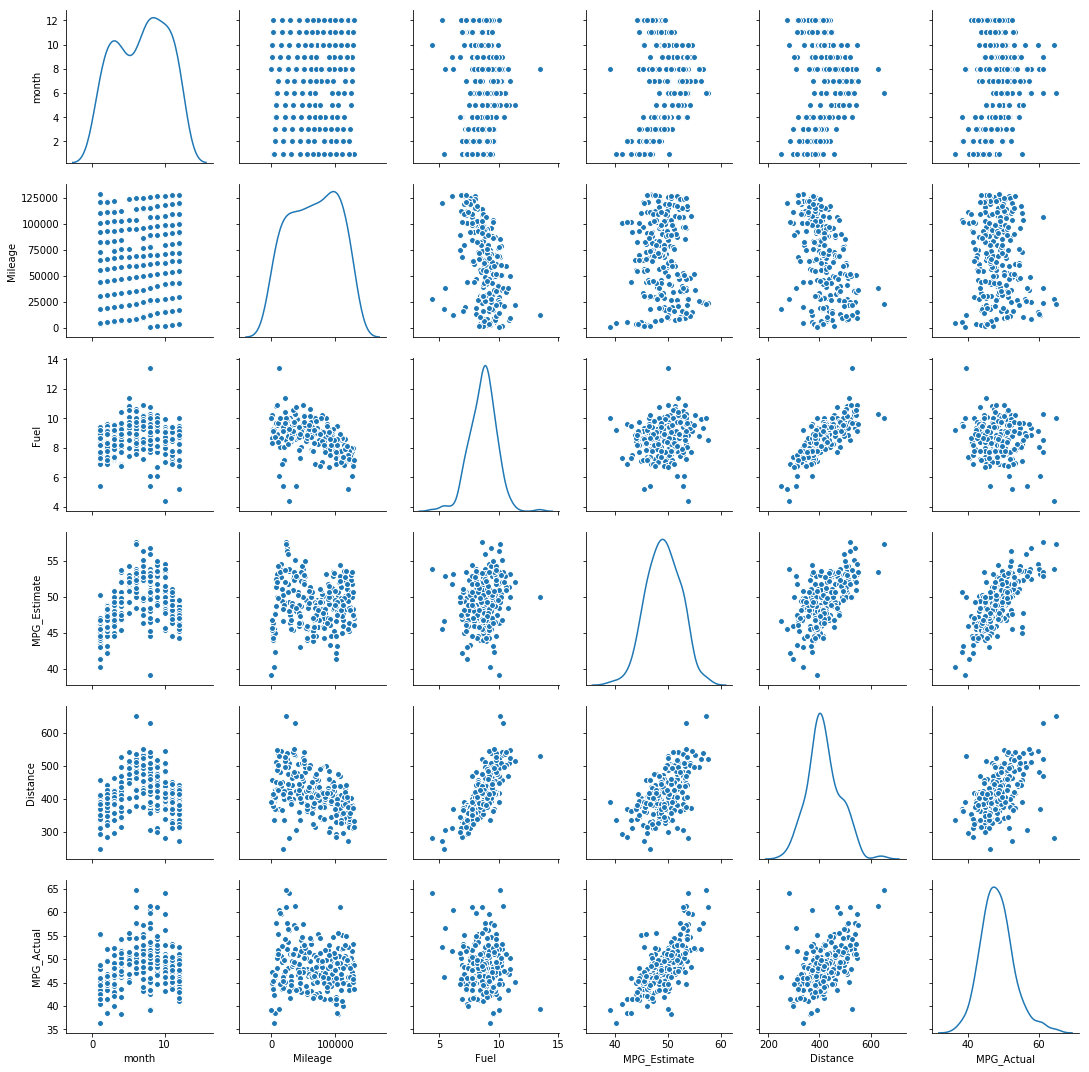

In [7]:
sns.pairplot(train_dataset[["month", "Mileage", "Fuel", "MPG_Estimate", "Distance", "MPG_Actual"]], diag_kind="kde")

Now display the overall statistics

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG_Actual")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mileage,247.0,66479.417004,37520.922922,391.00,33815.5000,68106.000,98924.500,128696.000
Fuel,247.0,8.652591,1.115571,4.38,7.9375,8.716,9.326,13.413
MPG_Estimate,247.0,49.195142,3.181894,39.10,46.9500,49.200,51.450,57.600
Distance,247.0,417.145749,63.913329,249.00,378.5000,412.000,455.000,651.000
month,247.0,6.777328,3.531941,1.00,4.0000,7.000,10.000,12.000


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [9]:
train_labels = train_dataset.pop('MPG_Actual')
test_labels = test_dataset.pop('MPG_Actual')

Displaying the train_dataset shows that the MPG_Actual field has been removed.

In [10]:
train_dataset.tail()

,Mileage,Fuel,MPG_Estimate,Distance,month
69,30605,8.647,46.7,384,1
205,89495,9.053,50.6,461,8
85,38203,5.427,52.9,307,8
172,75720,8.966,49.2,376,4
123,55219,8.880,44.2,381,12


### Normalize the data

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.tail()

,Mileage,Fuel,MPG_Estimate,Distance,month
69,-0.956118,-0.005012,-0.784169,-0.518605,-1.635737
205,0.613407,0.358927,0.441516,0.686152,0.346176
85,-0.753617,-2.891426,1.164356,-1.723361,0.346176
172,0.246278,0.280940,0.001527,-0.643774,-0.786346
123,-0.300110,0.203850,-1.569864,-0.565543,1.478698


## The model

### Build the model

I'm using the `Sequential` model from the tutorial with two densely connected hidden layers, and an output layer that returns a single, continuous value.

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


Trying out the model by taking a batch of `10` examples from the training data and call `model.predict` on it.

In [14]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.20030183],
       [-0.18549803],
       [-0.03039255],
       [ 0.02808678],
       [-0.02670661],
       [-0.13259146],
       [ 0.20069736],
       [-0.14840567],
       [-0.29405826],
       [-0.22738193]], dtype=float32)

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [15]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,0.580998,0.555161,0.580998,0.151874,0.315253,0.151874,995
996,0.324250,0.333610,0.324250,0.102239,0.192977,0.102239,996
997,0.855079,0.638413,0.855079,0.061701,0.216838,0.061701,997
998,0.496651,0.485780,0.496651,0.161923,0.336702,0.161923,998
999,0.477896,0.439385,0.477896,0.118887,0.289937,0.118887,999


Display the history of training the model and how well it performs against the validation data.

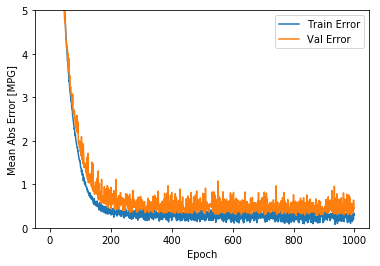

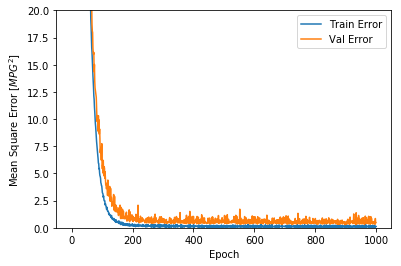

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)

I got pretty lucky above such that there isn't much room for improvement.  However, here is an example of early stopping in case the model starts overfitting.


....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................................

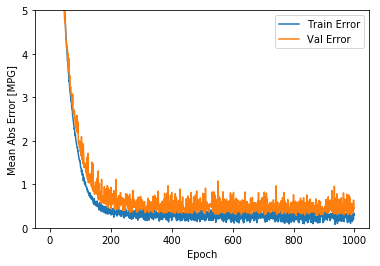

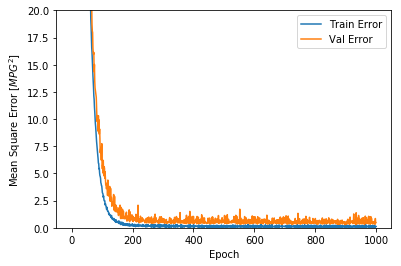

In [18]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Now it's time to see how well the model generalizes by using the **test** set, which wasn't used when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  0.37 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

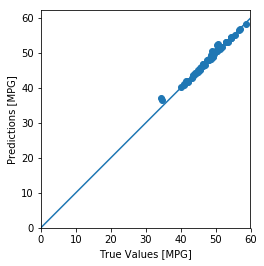

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like the model predicts reasonably well. Time to take a look at the error distribution.

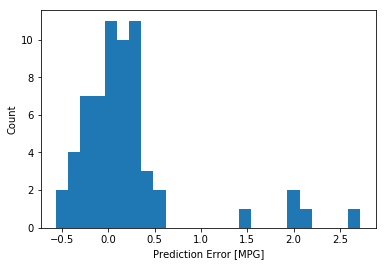

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

As in the Tensorflow tutorial, it's not quite gaussian, but not too bad given that the number of samples is very small.